<a href="https://colab.research.google.com/github/toyinjoy/Projects/blob/main/Policy_Renewal_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import pandas as pd

# Load data
df = pd.read_csv('/content/Fake_Insurance_Claim_Data.csv')

# Peek at the data
df.head()



,age,gender,policy_type,State,num_claims,claim_history_amount,claim_description,claim_cost,claim_date
0,51,Female,Auto,VA,1,38953.77,Tree fell on car,65053.86,2024-09-03
1,19,Male,Auto,OR,5,15886.08,Slip and fall injury,92595.50,2023-10-11
2,63,Male,Life,LA,0,33747.64,Fire damage to kitchen,83091.80,2024-04-19
3,57,Male,Home,MN,5,43479.39,Water damage from burst pipe,83972.96,2024-03-21
4,64,Female,Home,MA,3,34402.38,Storm damage to roof,8414.67,2025-01-28


In [12]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

# Define features and target
X = df.drop(columns=['claim_cost', 'claim_date'])  # Exclude target and date
y = df['claim_cost']

# Identify categorical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Preprocessing pipeline
preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
], remainder='passthrough')

# Full pipeline with model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: ${mae:,.2f}")
print(f"R² Score: {r2 * 100:.2f}%")


Mean Absolute Error: $28,135.03
R² Score: -36.01%


In [33]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta

# Set seed
np.random.seed(42)

# Parameters
n = 500

# Helper functions
def random_date(start, end):
    return start + timedelta(days=np.random.randint(0, (end - start).days))

states = ['NY', 'CA', 'TX', 'FL', 'IL']
policy_types = ['Auto', 'Home', 'Life']
program_codes = ['A', 'B', 'C', 'D']
networks = ['NetA', 'NetB', 'NetC']
companies = ['InsureCo A', 'InsureCo B', 'InsureCo C']
sources = ['Portal', 'Agent', 'Referral']

# Generate DataFrame
df = pd.DataFrame({
    'policy_id': np.arange(10001, 10001 + n),
    'policy_type': np.random.choice(policy_types, n),
    'policy_type_code': np.random.choice(['AUTO1', 'HOME2', 'LIFE3'], n),
    'policy_issue_state': np.random.choice(states, n),
    'policy_holder': ['Holder_' + str(i) for i in range(n)],
    'policy_holder_unique_id': ['UID' + str(i) for i in range(n)],
    'policy_inception_date': [random_date(datetime(2020,1,1), datetime(2023,1,1)) for _ in range(n)],
    'lost_business_reason': np.random.choice(['Price', 'Service', 'Competitor', None], n, p=[0.2, 0.2, 0.2, 0.4]),
    'program_code': np.random.choice(program_codes, n),
    'network': np.random.choice(networks, n),
    'is_quote': np.random.choice([True, False], n, p=[0.3, 0.7]),
    'is_pseudo': np.random.choice([True, False], n, p=[0.1, 0.9]),
    'issue_company': np.random.choice(companies, n),
    'record_source': np.random.choice(sources, n)
})

# Generate cancel dates (some will be null)
df['policy_cancel_date'] = df['policy_inception_date'] + pd.to_timedelta(np.random.randint(30, 1000, size=n), unit='D')
df.loc[np.random.rand(n) < 0.5, 'policy_cancel_date'] = pd.NaT

# Add target column: policy_renewed
df['policy_renewed'] = np.where(df['policy_cancel_date'].isna(), 'Renewed', 'Not Renewed')

# Review
df.head()


,policy_id,policy_type,policy_type_code,policy_issue_state,policy_holder,policy_holder_unique_id,policy_inception_date,lost_business_reason,program_code,network,is_quote,is_pseudo,issue_company,record_source,policy_cancel_date,policy_renewed
0,10001,Life,HOME2,TX,Holder_0,UID0,2021-03-07,Competitor,B,NetB,False,False,InsureCo A,Agent,NaT,Renewed
1,10002,Auto,HOME2,TX,Holder_1,UID1,2021-12-05,None,D,NetB,False,False,InsureCo B,Portal,NaT,Renewed
2,10003,Life,LIFE3,IL,Holder_2,UID2,2022-08-06,None,A,NetA,True,False,InsureCo A,Referral,NaT,Renewed
3,10004,Life,HOME2,FL,Holder_3,UID3,2021-08-07,Price,B,NetA,True,False,InsureCo A,Referral,NaT,Renewed
4,10005,Auto,AUTO1,CA,Holder_4,UID4,2021-02-02,Service,B,NetA,False,False,InsureCo C,Referral,2022-08-15,Not Renewed


In [34]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt


# Step 1: Encode target
df['policy_renewed_flag'] = df['policy_renewed'].map({'Renewed': 1, 'Not Renewed': 0})

# Step 2: Select features
features = [
    'policy_type', 'policy_type_code', 'policy_issue_state',
    'program_code', 'network', 'is_quote', 'is_pseudo',
    'issue_company', 'record_source'
]
X = df[features]
y = df['policy_renewed_flag']

# Step 3: Encode categorical variables
X_encoded = pd.get_dummies(X, drop_first=True)

# Step 4: Split data
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Step 5: Train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Step 6: Evaluate
y_pred = model.predict(X_test)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Optional: Add predictions to your dataframe
df['predicted_renewal'] = model.predict(X_encoded)
df['predicted_renewal_label'] = df['predicted_renewal'].map({1: 'Renewed', 0: 'Not Renewed'})


Confusion Matrix:
 [[25 20]
 [34 21]]

Classification Report:
               precision    recall  f1-score   support

           0       0.42      0.56      0.48        45
           1       0.51      0.38      0.44        55

    accuracy                           0.46       100
   macro avg       0.47      0.47      0.46       100
weighted avg       0.47      0.46      0.46       100



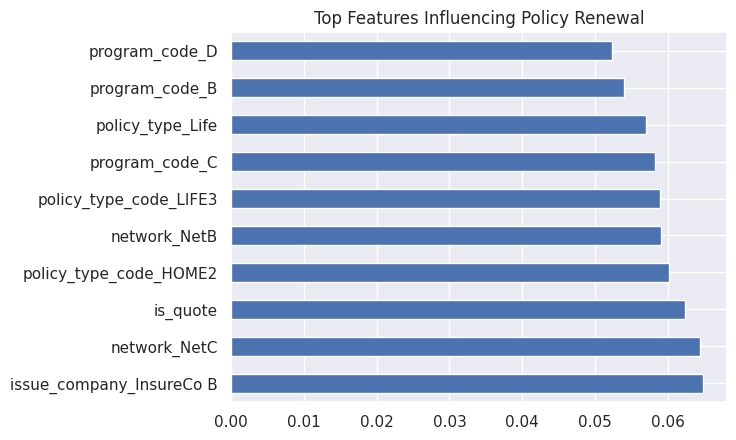

In [35]:
importances = model.feature_importances_
feat_names = X_encoded.columns

pd.Series(importances, index=feat_names).nlargest(10).plot(kind='barh')
plt.title("Top Features Influencing Policy Renewal")
plt.show()


In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, HalvingGridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, classification_report
import pandas as pd
import numpy as np


In [37]:


features_columns = X_encoded.columns
target_column = 'policy_renewed_flag'
results = pd.DataFrame()
reports = []
models = []

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold_idx, (train_idx, test_idx) in enumerate(kf.split(X_encoded, y)):
    X_train, X_test = X_encoded.iloc[train_idx], X_encoded.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Hyperparameter tuning
    param_grid = {
        'C': [0.1, 1.0, 10.0],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga'],
        'max_iter': [100, 200],
        'fit_intercept': [True, False]
    }

    clf = LogisticRegression(n_jobs=-1)
    gsh = HalvingGridSearchCV(estimator=clf, param_grid=param_grid, cv=3, verbose=0)
    gsh.fit(X_train, y_train)

    best_params = gsh.best_params_
    best_params["n_jobs"] = -1
    print(f"Fold {fold_idx}: Best Params:\n{best_params}")

    # Final model
    clf = LogisticRegression(**best_params)
    clf.fit(X_train, y_train)

    # Evaluation
    y_pred = clf.predict(X_test)
    results.at[fold_idx, "Mic-F1"] = f1_score(y_test, y_pred, average='micro')
    results.at[fold_idx, "Mac-F1"] = f1_score(y_test, y_pred, average='macro')
    results.at[fold_idx, "Wei-F1"] = f1_score(y_test, y_pred, average='weighted')
    reports.append(classification_report(y_test, y_pred, output_dict=True))

results["fold"] = results.index


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  

Fold 0: Best Params:
{'C': 1.0, 'fit_intercept': False, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear', 'n_jobs': -1}


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  

Fold 1: Best Params:
{'C': 0.1, 'fit_intercept': True, 'max_iter': 200, 'penalty': 'l1', 'solver': 'liblinear', 'n_jobs': -1}


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  

Fold 2: Best Params:
{'C': 1.0, 'fit_intercept': True, 'max_iter': 200, 'penalty': 'l1', 'solver': 'liblinear', 'n_jobs': -1}


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  

Fold 3: Best Params:
{'C': 10.0, 'fit_intercept': False, 'max_iter': 200, 'penalty': 'l1', 'solver': 'saga', 'n_jobs': -1}


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  

Fold 4: Best Params:
{'C': 0.1, 'fit_intercept': True, 'max_iter': 200, 'penalty': 'l1', 'solver': 'liblinear', 'n_jobs': -1}


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


In [38]:
print(results)


   Mic-F1    Mac-F1    Wei-F1  fold
0    0.54  0.533279  0.534399     0
1    0.53  0.493043  0.498518     1
2    0.55  0.544488  0.546493     2
3    0.56  0.557166  0.558583     3
4    0.54  0.506650  0.511780     4


In [47]:
# Install if needed (for Databricks or Colab)
# %pip install imbalanced-learn

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE

# 1. Generate synthetic insurance policy data
np.random.seed(42)
n = 1000

def random_date(start, end, n):
    return [start + timedelta(days=np.random.randint(0, (end - start).days)) for _ in range(n)]

states = ['NY', 'CA', 'TX', 'FL', 'IL']
policy_types = ['Auto', 'Home', 'Life']
program_codes = ['A', 'B', 'C', 'D']
networks = ['NetA', 'NetB', 'NetC']
companies = ['InsureCo A', 'InsureCo B', 'InsureCo C']
sources = ['Portal', 'Agent', 'Referral']

df = pd.DataFrame({
    'policy_id': np.arange(10001, 10001 + n),
    'policy_type': np.random.choice(policy_types, n),
    'policy_type_code': np.random.choice(['AUTO1', 'HOME2', 'LIFE3'], n),
    'policy_issue_state': np.random.choice(states, n),
    'program_code': np.random.choice(program_codes, n),
    'network': np.random.choice(networks, n),
    'is_quote': np.random.choice([True, False], n, p=[0.3, 0.7]),
    'is_pseudo': np.random.choice([True, False], n, p=[0.1, 0.9]),
    'issue_company': np.random.choice(companies, n),
    'record_source': np.random.choice(sources, n),
    'policy_inception_date': random_date(datetime(2020,1,1), datetime(2024,1,1), n),
    'lost_business_reason': np.random.choice(['Price', 'Service', 'Competitor', None], n, p=[0.2, 0.2, 0.2, 0.4])
})

# Simulate policy_cancel_date and policy_renewed with signal logic
df['today'] = pd.Timestamp('2025-06-16')
df['policy_cancel_date'] = df['policy_inception_date'] + pd.to_timedelta(np.random.randint(90, 900, size=n), unit='D')
df.loc[(df['is_quote']) | (df['lost_business_reason'].notna()), 'policy_cancel_date'] = pd.Timestamp('2023-12-31')
df.loc[np.random.rand(n) < 0.3, 'policy_cancel_date'] = pd.NaT

df['policy_renewed'] = np.where(df['policy_cancel_date'].isna(), 'Renewed', 'Not Renewed')

# Feature engineering
df['policy_age_days'] = (df['today'] - df['policy_inception_date']).dt.days
df['policy_duration_days'] = (df['policy_cancel_date'] - df['policy_inception_date']).dt.days.fillna(df['policy_age_days'])
df['has_lost_reason'] = df['lost_business_reason'].notna().astype(int)
df['was_recent'] = (df['policy_inception_date'] > pd.Timestamp('2023-01-01')).astype(int)
df['policy_renewed_flag'] = df['policy_renewed'].map({'Renewed': 1, 'Not Renewed': 0})

# Modeling
features = [
    'policy_type', 'policy_issue_state', 'program_code', 'network',
    'is_quote', 'is_pseudo', 'issue_company', 'record_source',
    'policy_age_days', 'policy_duration_days', 'has_lost_reason', 'was_recent'
]
target = 'policy_renewed_flag'

X = df[features]
y = df[target]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Preprocessing
categorical_features = ['policy_type', 'policy_issue_state', 'program_code', 'network', 'issue_company', 'record_source']
numeric_features = ['policy_age_days', 'policy_duration_days', 'has_lost_reason', 'was_recent', 'is_quote', 'is_pseudo']

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features),
    ('num', 'passthrough', numeric_features)
])

# Oversample
ohe_X_train = preprocessor.fit_transform(X_train)
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(ohe_X_train, y_train)

# Train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_resampled, y_resampled)

# Evaluate
X_test_encoded = preprocessor.transform(X_test)
y_pred = model.predict(X_test_encoded)
report = classification_report(y_test, y_pred, output_dict=True)

report_df = pd.DataFrame(report).T
report_df[['precision', 'recall', 'f1-score']] = report_df[['precision', 'recall', 'f1-score']].round(2)

print(report_df)


              precision  recall  f1-score  support
0                  0.98    0.98      0.98   139.00
1                  0.95    0.95      0.95    61.00
accuracy           0.97    0.97      0.97     0.97
macro avg          0.96    0.96      0.96   200.00
weighted avg       0.97    0.97      0.97   200.00


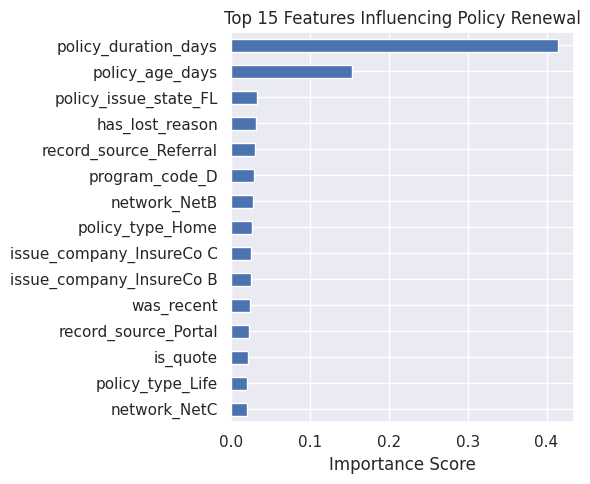

In [49]:
import matplotlib.pyplot as plt

# Get feature names after encoding
encoded_cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
final_feature_names = np.concatenate([encoded_cat_features, numeric_features])

# Get feature importances from the model
importances = model.feature_importances_

# Create a Series for easy sorting and plotting
feat_series = pd.Series(importances, index=final_feature_names).sort_values(ascending=True)

# Plot
plt.figure(figsize=(6, 5))
feat_series.tail(15).plot(kind='barh')
plt.title('Top 15 Features Influencing Policy Renewal')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.grid(True)
plt.show()


In [52]:
# Retrainable ML Pipeline for Policy Renewal Prediction

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
import joblib
import os

# Paths for saving model and encoder
MODEL_PATH = 'models/policy_model.pkl'
ENCODER_PATH = 'models/encoder.pkl'

# Ensure model directory exists
os.makedirs('models', exist_ok=True)

# --- Step 1: Load or Simulate Data ---
def load_data():
    # For production, replace this with loading from DB or API
    np.random.seed(42)
    n = 1000

    def random_date(start, end, n):
        return [start + timedelta(days=np.random.randint(0, (end - start).days)) for _ in range(n)]

    df = pd.DataFrame({
        'policy_id': np.arange(10001, 10001 + n),
        'policy_type': np.random.choice(['Auto', 'Home', 'Life'], n),
        'policy_issue_state': np.random.choice(['NY', 'CA', 'TX', 'FL', 'IL'], n),
        'program_code': np.random.choice(['A', 'B', 'C', 'D'], n),
        'network': np.random.choice(['NetA', 'NetB', 'NetC'], n),
        'is_quote': np.random.choice([True, False], n, p=[0.3, 0.7]),
        'is_pseudo': np.random.choice([True, False], n, p=[0.1, 0.9]),
        'issue_company': np.random.choice(['InsureCo A', 'InsureCo B', 'InsureCo C'], n),
        'record_source': np.random.choice(['Portal', 'Agent', 'Referral'], n),
        'policy_inception_date': random_date(datetime(2020,1,1), datetime(2024,1,1), n),
        'lost_business_reason': np.random.choice(['Price', 'Service', 'Competitor', None], n, p=[0.2, 0.2, 0.2, 0.4])
    })

    df['today'] = pd.Timestamp.today()
    df['policy_cancel_date'] = df['policy_inception_date'] + pd.to_timedelta(np.random.randint(90, 900, size=n), unit='D')
    df.loc[(df['is_quote']) | (df['lost_business_reason'].notna()), 'policy_cancel_date'] = pd.Timestamp('2023-12-31')
    df.loc[np.random.rand(n) < 0.3, 'policy_cancel_date'] = pd.NaT

    df['policy_renewed'] = np.where(df['policy_cancel_date'].isna(), 'Renewed', 'Not Renewed')
    df['policy_age_days'] = (df['today'] - df['policy_inception_date']).dt.days
    df['policy_duration_days'] = (df['policy_cancel_date'] - df['policy_inception_date']).dt.days.fillna(df['policy_age_days'])
    df['has_lost_reason'] = df['lost_business_reason'].notna().astype(int)
    df['was_recent'] = (df['policy_inception_date'] > pd.Timestamp('2023-01-01')).astype(int)
    df['policy_renewed_flag'] = df['policy_renewed'].map({'Renewed': 1, 'Not Renewed': 0})

    return df

# --- Step 2: Train or Retrain Model ---
def train_model(df):
    features = [
        'policy_type', 'policy_issue_state', 'program_code', 'network',
        'is_quote', 'is_pseudo', 'issue_company', 'record_source',
        'policy_age_days', 'policy_duration_days', 'has_lost_reason', 'was_recent'
    ]
    target = 'policy_renewed_flag'

    X = df[features]
    y = df[target]

    cat_features = ['policy_type', 'policy_issue_state', 'program_code', 'network', 'issue_company', 'record_source']
    num_features = ['policy_age_days', 'policy_duration_days', 'has_lost_reason', 'was_recent', 'is_quote', 'is_pseudo']

    encoder = ColumnTransformer([
        ('cat', OneHotEncoder(drop='first', sparse_output=False), cat_features),
        ('num', 'passthrough', num_features)
    ])

    X_encoded = encoder.fit_transform(X)

    smote = SMOTE(random_state=42)
    X_res, y_res = smote.fit_resample(X_encoded, y)

    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_res, y_res)

    joblib.dump(model, MODEL_PATH)
    joblib.dump(encoder, ENCODER_PATH)
    print("✅ Model and encoder saved.")

    return model, encoder

# --- Step 3: Predict with Latest Data ---
def predict(df, model, encoder):
    features = [
        'policy_type', 'policy_issue_state', 'program_code', 'network',
        'is_quote', 'is_pseudo', 'issue_company', 'record_source',
        'policy_age_days', 'policy_duration_days', 'has_lost_reason', 'was_recent'
    ]
    X = df[features]
    X_encoded = encoder.transform(X)
    predictions = model.predict(X_encoded)
    df['predicted_label'] = np.where(predictions == 1, 'Renewed', 'Not Renewed')
    return df

# Run the pipeline
if __name__ == "__main__":
    data = load_data()
    model, encoder = train_model(data)
    scored_data = predict(data, model, encoder)
    print(scored_data[['policy_id', 'policy_renewed', 'predicted_label']].head(100))

✅ Model and encoder saved.
    policy_id policy_renewed predicted_label
0       10001        Renewed         Renewed
1       10002    Not Renewed     Not Renewed
2       10003        Renewed         Renewed
3       10004        Renewed         Renewed
4       10005        Renewed         Renewed
..        ...            ...             ...
95      10096    Not Renewed     Not Renewed
96      10097    Not Renewed     Not Renewed
97      10098    Not Renewed     Not Renewed
98      10099        Renewed         Renewed
99      10100        Renewed         Renewed

[100 rows x 3 columns]
